# Urban Sound RNN Classification

### Introduction

This Jupyter notebook was created by Filipe Barros, Gonçalo Arrobas and João Barão for the Machine Learning II.

### Authorship

Author: Filipe Barros, Gonçalo Arrobas and João Barão
University: Faculty of Science from University of Porto
Course: Machine Learning II
Sound Classification Problem

For this project, the students were tasked with the development of a deed learning model for audio classification. The data from the UrbanSound8K dataset was used throughout the development of this project. This dataset contains a total of 8732 labeled audio recordings of urban sounds, each with a duration of up to four seconds. Each excerpts has been labeled with one of the following classes:

0 = air_conditioner

1 = car_horn

2 = children_playing

3 = dog_bark

4 = drilling

5 = engine_idling

6 = gun_shot

7 = jackhammer

8 = siren

9 = street_music

The objective of this project relies on defining, compiling, training and evaluating two Deep Learning (DL) classifiers. The DL model types to be considered are:

Multilayer Perceptron (MLP)
Convolutional Neural Network (CNN)
Recurrent Neural Network (RNN)

### Import Statements

In [66]:
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from tensorflow.keras import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Bidirectional, Conv2D, MaxPooling2D, GlobalAveragePooling2D, SpatialDropout2D, Flatten, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam, SGD
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
import keras_tuner as kt
import keras.backend as keras_backend
import matplotlib.image as mpimg
from keras_tuner.tuners import Hyperband

### Data Analysis

In [67]:
print("Loading CSV file {}".format('UrbanSound8K.csv'))

# Load metadata as a Pandas dataframe
metadata = pd.read_csv('UrbanSound8K.csv')

# Examine dataframe's head
metadata.head()

Loading CSV file UrbanSound8K.csv


,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


#### Class Distribution

In [68]:
metadata['class'].value_counts()

class
dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: count, dtype: int64

In [69]:
# Inicializar listas vazias para carregar os dados
X_folds = []
y_folds = []
X_folds_aug = []
y_folds_aug = []


le = LabelEncoder()

# Carregar e plotar cada fold
for i in range(10):
    X_fold_aug = np.load(f'fold{i + 1}_features_augmented.npy', allow_pickle=True)
    y_fold_aug = np.load(f'fold{i + 1}_labels_augmented.npy', allow_pickle=True)
    X_fold = np.load(f'fold{i + 1}features.npy', allow_pickle=True)
    y_fold = np.load(f'fold{i + 1}labels.npy', allow_pickle=True)

    scalers = {}
    scalers_aug = {}
    for i in range(X_fold.shape[1]):
        scalers[i] = StandardScaler()
        X_fold[:, i, :] = scalers[i].fit_transform(X_fold[:, i, :])
    for i in range(X_fold_aug.shape[1]):
        scalers_aug[i] = StandardScaler()
        X_fold_aug[:, i, :] = scalers_aug[i].fit_transform(X_fold_aug[:, i, :])
    y_fold = to_categorical(le.fit_transform(y_fold))
    y_fold_aug = to_categorical(le.fit_transform(y_fold_aug))

    X_folds.append(X_fold)
    y_folds.append(y_fold)
    X_folds_aug.append(X_fold_aug)
    y_folds_aug.append(y_fold_aug)

### Model Architecture

We chose the Adam optimizer in our work due to its efficiency and effectiveness in handling large datasets and complex models. Adam combines the advantages of two other popular optimizers, AdaGrad and RMSProp, by using adaptive learning rates for each parameter. This helps in faster convergence and reduces the need for manual tuning of learning rates. Additionally, Adam's ability to correct biases in moment estimates, particularly during the initial training phases, makes it well-suited for a wide range of machine learning tasks, improving both training speed and model performance.

In [1]:
def create_tunable_lstm_model(hp):
    model = Sequential()

    # Hyperparameter tuning for LSTM units
    units = hp.Int('units', min_value=64, max_value=512, step=64)
    dense_units = hp.Int('units', min_value=64, max_value=512, step=64)

    # Hyperparameter tuning for dropout rate
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)

    # Hyperparameter tuning for L2 regularization
    l2_reg = hp.Float('l2_reg', min_value=0.0001, max_value=0.01, sampling='log')

    # Bidirectional LSTM layers
    model.add(Bidirectional(LSTM(units, return_sequences=True, kernel_regularizer=l2(l2_reg)), input_shape=(40, 174)))
    model.add(Dropout(dropout_rate))
    
    model.add(Bidirectional(LSTM(units // 2, return_sequences=True, kernel_regularizer=l2(l2_reg))))
    model.add(Dropout(dropout_rate))
    
    model.add(Bidirectional(LSTM(units // 4, return_sequences=False, kernel_regularizer=l2(l2_reg))))
    model.add(Dropout(dropout_rate))

    # Dense layers
    model.add(Dense(dense_units, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(10, activation='softmax'))

    # Hyperparameter tuning for optimizer
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'rmsprop', 'nadam', 'sgd'])

    # Hyperparameter tuning for learning rate
    learning_rate = hp.Float('learning_rate', min_value=0.00001, max_value=0.01, sampling='log')

    # Define optimizer based on choice
    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer_choice == 'nadam':
        optimizer = Nadam(learning_rate=learning_rate)
    elif optimizer_choice == 'sgd':
        optimizer = SGD(learning_rate=learning_rate, momentum=0.9)

    # Compile the model
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [71]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor; commonly 'val_loss' or 'val_accuracy'
    patience=3,          # Number of epochs to wait after no improvement
    restore_best_weights=True,  # Restores model weights to the best epoch with the lowest monitored metric
    verbose=1            # Print messages when early stopping is triggered
)

# Define the tuner
tuner = Hyperband(
    create_tunable_lstm_model,
    objective='val_accuracy',
    max_epochs=30,
    factor=3,
    directory='hyperband_dir2',
    project_name='lstm_hyperband_tuning_5'
)

X_val = X_folds[0]
y_val = y_folds[0]
X_train = np.concatenate([X_folds[j] for j in range(10) if j != 0], axis=0)
y_train = np.concatenate([y_folds[j] for j in range(10) if j != 0], axis=0)

# Run the tuner search
tuner.search(X_train, y_train, epochs=30, validation_data=(X_val, y_val), batch_size=128, callbacks=[early_stopping])

# Get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters()[0]

Reloading Tuner from hyperband_dir2/lstm_hyperband_tuning_5/tuner0.json


In [72]:
print(f"""
The optimal hyperparameters are:
- Units: {best_hyperparameters.get('units')}
- Dropout Rate: {best_hyperparameters.get('dropout_rate')}
- L2 Regularization: {best_hyperparameters.get('l2_reg')}
- Learning Rate: {best_hyperparameters.get('learning_rate')}
""")


The optimal hyperparameters are:
- Units: 192
- Dropout Rate: 0.4
- L2 Regularization: 0.000991392375288556
- Learning Rate: 0.001



In [73]:
print(X_folds[0][0].shape)

(40, 174)


In [74]:
def create_bidirectional_lstm_model(input_shape=(40,174), units=256, dropout_rate=0.4, l2_reg=0.005):
    model = Sequential()
    
    # First Bidirectional LSTM layer with L2 regularization
    model.add(Bidirectional(LSTM(units, return_sequences=True, kernel_regularizer=l2(l2_reg)), input_shape=input_shape))
    model.add(Dropout(dropout_rate))

    # First Bidirectional LSTM layer with L2 regularization
    model.add(Bidirectional(LSTM(units // 2, return_sequences=True, kernel_regularizer=l2(l2_reg)), input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    
    # Second Bidirectional LSTM layer with L2 regularization
    model.add(Bidirectional(LSTM(units // 4, return_sequences=False, kernel_regularizer=l2(l2_reg)), input_shape = input_shape))
    model.add(Dropout(dropout_rate))
    
    # Dense layer with L2 regularization
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))
    
    # Output layer for multi-class classification
    model.add(Dense(10, activation='softmax'))  # Adjust '10' to the number of classes in your dataset

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [75]:
def plot_graphs(history, y_true, y_pred, class_labels):
    # Create a 1x3 grid for subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 4))

    # Plot accuracy values
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Validation'], loc='upper left')

    # Plot loss values
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Validation'], loc='upper left')

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, ax=axs[2])
    axs[2].set_title('Confusion Matrix')
    axs[2].set_xlabel('Predicted')
    axs[2].set_ylabel('True')

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [76]:
initial_lr = 0.0001  # Define the base learning rate

def lr_schedule(epoch):
    if epoch < 5:
        return initial_lr  # Use the initial learning rate directly
    elif epoch < 15:
        return initial_lr * 0.25  # Reduce to 10% of the initial learning rate
    elif epoch < 30:
        return initial_lr * 0.1  # Reduce to 1% of the initial learning rate
    else:
        return initial_lr * 0.1

lr_scheduler = LearningRateScheduler(lr_schedule)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor; commonly 'val_loss' or 'val_accuracy'
    patience=3,          # Number of epochs to wait after no improvement
    restore_best_weights=True,  # Restores model weights to the best epoch with the lowest monitored metric
    verbose=1            # Print messages when early stopping is triggered
)

### Model Analysis and Results


Training fold 1...
Epoch 1/50


/opt/anaconda3/envs/RNN/lib/python3.11/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 192ms/step - accuracy: 0.1520 - loss: 13.1158 - val_accuracy: 0.2579 - val_loss: 11.6590
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 211ms/step - accuracy: 0.2300 - loss: 11.3392 - val_accuracy: 0.2714 - val_loss: 10.0685
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 265ms/step - accuracy: 0.2816 - loss: 9.8421 - val_accuracy: 0.3041 - val_loss: 8.7557
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 272ms/step - accuracy: 0.2944 - loss: 8.5854 - val_accuracy: 0.3367 - val_loss: 7.6173
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 276ms/step - accuracy: 0.3643 - loss: 7.4567 - val_accuracy: 0.4628 - val_loss: 6.5208
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 270ms/step - accuracy: 0.4224 - loss: 6.4641 - val_accuracy: 0.5158 - val_loss: 5.7463
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 272ms/step - accuracy: 0.4722 - loss: 5.7201 - val_accuracy: 0.5214 - val_loss: 5.1033
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 270ms/step - accuracy: 0.5027 - loss: 5.1332 - val_accuracy: 0

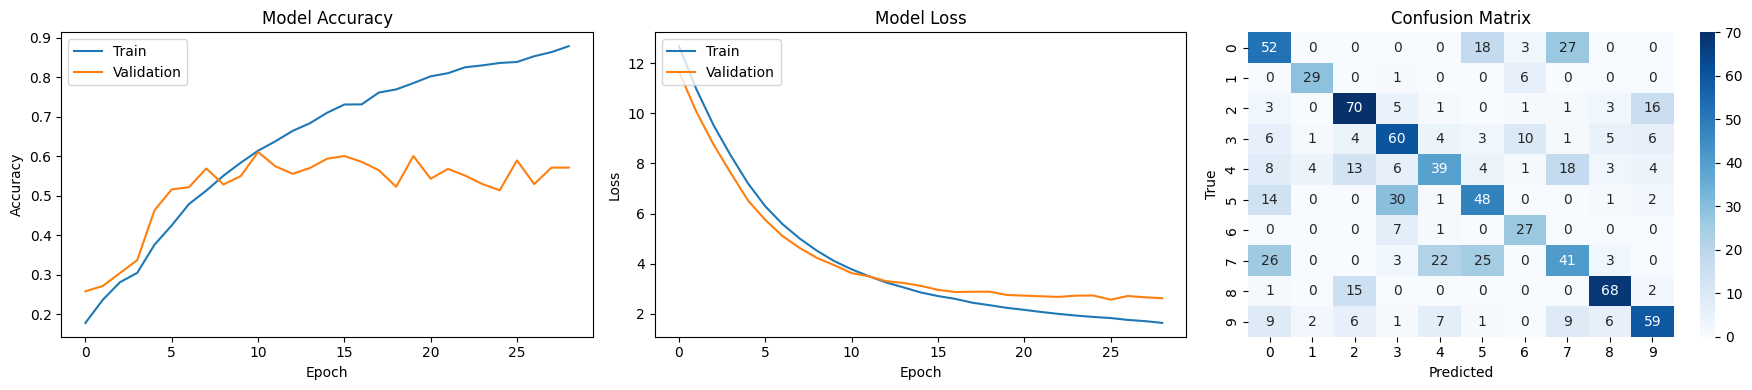

Fold 1 Test Accuracy: 0.5647

Average Accuracy across 10 folds: 56.4719%
Standard Deviation: 0.0000%


In [77]:
num_folds = 10
fold_accuracies = []

for i in range(num_folds):
    if i<1:
        # Define the test and validation indices
        test_idx = i
        val_idx = (i + 1) % num_folds
        
        # Split the data accordingly
        X_test = X_folds[test_idx]
        y_test = y_folds[test_idx]
        X_val = X_folds[val_idx]
        y_val = y_folds[val_idx]

        # Combine the remaining folds for training
        X_train = np.concatenate([X_folds[j] for j in range(num_folds) if j != test_idx and j != val_idx], axis=0)
        y_train = np.concatenate([y_folds[j] for j in range(num_folds) if j != test_idx and j != val_idx], axis=0)

        # Create a new model instance for each fold
        model = create_bidirectional_lstm_model()
        
        # Train the model
        print(f"\nTraining fold {i + 1}...")

        callbacks = [early_stopping, lr_schedule]

        # Use in the model training
        history = model.fit(X_train, y_train, 
                            validation_data=(X_val, y_val),
                            epochs=50,
                            batch_size=128,
                            callbacks=[early_stopping, lr_schedule])


        predictions_LSTM = model.predict(X_test)
        predicted_labels_LSTM = np.argmax(predictions_LSTM, axis=1)

        y_test_multiclass = np.argmax(y_test, axis=1)
        
        plot_graphs(history, y_test_multiclass, predicted_labels_LSTM, class_labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

        # Evaluate on the test set
        test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
        print(f"Fold {i + 1} Test Accuracy: {test_acc:.4f}")
        
        # Save the accuracy for later analysis
        fold_accuracies.append(test_acc)

# Print average accuracy across all folds
average_accuracy = np.mean(fold_accuracies)
print(f"\nAverage Accuracy across {num_folds} folds: {average_accuracy*100:.4f}%")
print(f"Standard Deviation: {np.std(fold_accuracies)*100:.4f}%")
